
##  1. The following cell contains the libraries needed for calculation

In [1]:
import numpy as np
import pandas as pd

from pylife.stress.histogram import *
import pylife.stress.timesignal as ts
from pylife.stress.rainflow import *
import pylife.stress.equistress

import pylife.strength.meanstress
from pylife.strength import miner
from pylife.strength import sn_curve
from pylife.strength.miner import MinerElementar, MinerHaibach
from pylife.strength import failure_probability as fp

from pylife.materialdata.woehler.diagrams.woehler_curve_diagrams import WoehlerCurveDiagrams

import pylife.mesh.meshplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

from scipy.stats import norm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import io
from IPython.display import HTML
import base64

# mpl.style.use('seaborn')
# mpl.style.use('seaborn-notebook')
mpl.style.use('bmh')
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 2. Time series signal

1. The argument 'index' contains the name of the rows
2. The argument 'column' contains the name of the columns
3. The argument 'data' contains the data belonging to the column

 For importing data using pandas Dataframe check out the file named 'pandas.ipynb'

In [2]:


t = np.linspace(0,60,60*2048)  # Numbers between 0 and 60  divided into 60*2048 intervals 
files = ['wn','sine']          # 2048 is the frequency fo the wave data generated here


wn = pd.DataFrame(index = t, columns = ['sensor_1'], data = 120*np.random.randn(len(t))) #To create a dataset with t as the name of the rows and data as the sensor_1 column 
sine = pd.DataFrame(index = t, columns = ['sensor_1'], data = 80*np.sin(2*np.pi*50*t))

input_data = [wn,sine]         # List which contains both wn and sine dataset so the length is 2
  

    
print(len(input_data))  
wn

2


sensor_1
0.000000  -208.610430
0.000488   -96.489230
0.000977   116.895313
0.001465    96.175621
0.001953   -89.164323
...               ...
59.998047  -62.004818
59.998535   -8.246944
59.999023   18.003489
59.999512  -46.312800
60.000000   48.711587

[122880 rows x 1 columns]

# 3. Resampling

Here widget function has been used to create an interactive GUI which asks user's input for resampling frequency. For examples check the file widgets.ipynb

In [3]:

    # Float text widget with minimum value of 1 and maximum value of 100000 #
f_resample = widgets.FloatText(value = 1024,min=1,max=100e3,step=1,description='Resampling frequency [Hz]',
    disabled=False,readout=True,readout_format='d')
display(f_resample)




FloatText(value=1024.0, description='Resampling frequency [Hz]', step=1.0)

The following cell resamples the data of frequency 2048 Hz to the frequency specified by user input in the above widget

In [4]:
meas_resample = []
for file_act in input_data:
    #  Function for resampling the dataset of specified frequency #
    meas_resample.append(ts.TimeSignalPrep(file_act).resample_acc(f_resample.value))

meas_resample

[             sensor_1
 0.000000  -208.610430
 0.000977   116.891840
 0.001953   -89.158290
 0.002930   -24.789912
 0.003906    41.529749
 ...               ...
 59.996094   67.963220
 59.997070  155.539222
 59.998047  -62.003068
 59.999023   18.002442
 60.000000   48.711587
 
 [61441 rows x 1 columns],
                sensor_1
 0.000000   0.000000e+00
 0.000977   2.416047e+01
 0.001953   4.606464e+01
 0.002930   6.366692e+01
 0.003906   7.532347e+01
 ...                 ...
 59.996094 -7.532347e+01
 59.997070 -6.366692e+01
 59.998047 -4.606464e+01
 59.999023 -2.416047e+01
 60.000000 -8.152041e-11
 
 [61441 rows x 1 columns]]

The following cell creates a widget which asks for user input on which sensor data to plot

In [5]:

print("select channel to plot")
plotChan = widgets.Dropdown(options = file_act.columns)  # Dropdown widget function #
display(plotChan)



select channel to plot


Dropdown(options=('sensor_1',), value='sensor_1')

The following cell plots the data set (signal) of the chosen channel. It utilizes matplotlib function for plotting dataset

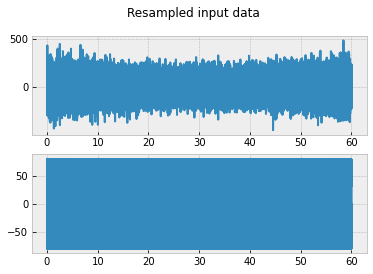

In [6]:


fig, ax = plt.subplots(len(meas_resample))  # Matplotlib function for creating plots
fig.suptitle('Resampled input data')        # For creating title name
ii = 0


#  Plots the value of index against the sensor data #
for df_act in meas_resample:    
    if len(meas_resample) == 1:
        ax.plot(df_act.index, df_act[plotChan.value])   #df_act.index will have the index values and df_act(plotchan:value) will have the sensor data
    
    #For creating more than one plot
    else:
        ax[ii].plot(df_act.index, df_act[plotChan.value]) 
    ii += 1



# 4. Fitering

Filtering the time series with a bandpass filter.

The following cell creates two Floattext widget for mentioning min and max frequency for bandpass filter

In [7]:
f_min = widgets.FloatText(value = 5,description='min frequency [Hz]',disabled=False)
f_max = widgets.FloatText(value = 100,description='max frequency [Hz]',disabled=False)
display(f_min)
display(f_max)



FloatText(value=5.0, description='min frequency [Hz]')

FloatText(value=100.0, description='max frequency [Hz]')

The following cell demonstrates the working of band pass filter for the above mentioned frequency range

In [8]:


bandpass = []                                       # Contains the bandpass filtered dataset

for df_act in meas_resample:
    
    bandpassDF = pd.DataFrame(index = df_act.index) # Takes in the index of the data set
    for col_act in df_act.columns:
                # Goes through each row of the datset and filters it #
        bandpassDF[col_act] = ts.TimeSignalPrep(df_act[col_act]).butter_bandpass(f_min.value,f_max.value,f_resample.value,5)
    bandpass.append(bandpassDF)

display(bandpass)

[             sensor_1
 0.000000   -31.047693
 0.000977    40.388271
 0.001953   103.085565
 0.002930   149.936057
 0.003906   176.715847
 ...               ...
 59.996094    7.526391
 59.997070   10.403201
 59.998047    5.829113
 59.999023   -5.378052
 60.000000  -20.428803
 
 [61441 rows x 1 columns],
             sensor_1
 0.000000   -8.334290
 0.000977   16.235787
 0.001953   38.536687
 0.002930   56.522427
 0.003906   68.551364
 ...              ...
 59.996094 -57.333291
 59.997070 -46.097896
 59.998047 -29.018910
 59.999023  -7.767885
 60.000000  15.587948
 
 [61441 rows x 1 columns]]

# 5. Running Statistics

The following cell creates widgets which asks for the type of statistics to be performed on the data set. 

In [9]:
print("select channel to for running stats")
runChan = widgets.Dropdown(options = df_act.columns)
display(runChan)
print(" Running statistics method")
method_choice = widgets.Dropdown(options = ['rms','max','min','abs'])
display(method_choice)

paraRunStats = ['window_length', 'buffer_overlap', 'limit']
values = [800,0.1,0.015]
child = [widgets.FloatText(description=name) for name in paraRunStats]
tab = widgets.Tab()
tab.children = child
for i in range(len(child)):
    tab.set_title(i, paraRunStats[i])
    tab.children[i].value = values[i]

tab

select channel to for running stats


Dropdown(options=('sensor_1',), value='sensor_1')

 Running statistics method


Dropdown(options=('rms', 'max', 'min', 'abs'), value='rms')

The function resample, butter_bandpass and running_stats_filt are functions of time signal generator.  For more information refer the file timesignal.py in the stress folder of the pylife library

The following cell performs the above mentioned statistics using the function time signal and the sub-function running_stats_filt

In [10]:
cleaned = []                        #Contains cleaned dataset after running the statistics

for df_act in bandpass:
    cleaned_df = ts.TimeSignalPrep(df_act).running_stats_filt(
                            col = runChan.value,
                            window_length = int(tab.children[0].value),
                            buffer_overlap = int(tab.children[1].value),
                            limit = tab.children[2].value,
                            method = method_choice.value)     #Performs statistics on the data set
    cleaned.append(cleaned_df)



with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cleaned)

[             sensor_1
0.000000   -31.047693
0.000977    40.388271
0.001953   103.085565
0.002930   149.936057
0.003906   176.715847
0.004883   182.607155
0.005859   170.106872
0.006836   144.530287
0.007812   113.217584
0.008789    84.392745
0.009766    65.630478
0.010742    62.114997
0.011719    75.161443
0.012695   101.579007
0.013672   134.267490
0.014648   164.030205
0.015625   182.149912
0.016602   182.991703
0.017578   165.847775
0.018555   135.417542
0.019531   100.681318
0.020508    72.395912
0.021484    59.875680
0.022461    67.979735
0.023438    95.241363
0.024414   133.851696
0.025391   171.746131
0.026367   196.365057
0.027344   198.947336
0.028320   177.811317
0.029297   139.288209
0.030273    95.800857
0.031250    61.685218
0.032227    48.243934
0.033203    59.824841
0.034180    92.321305
0.035156   134.574307
0.036133   172.100263
0.037109   191.788825
0.038086   185.973836
0.039062   154.598438
0.040039   104.898616
0.041016    48.865045
0.041992    -0.547296
0.042969 

In [11]:
print("select channel to plot")
plotChan = widgets.Dropdown(options = file_act.columns)
display(plotChan)

select channel to plot


Dropdown(options=('sensor_1',), value='sensor_1')

The following cell plots the above cleaned input data using the time signal function

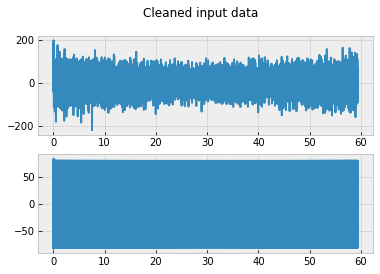

In [12]:
fig, ax = plt.subplots(len(meas_resample))
fig.suptitle('Cleaned input data')

for i, df_act in enumerate(cleaned):
    if len(meas_resample) == 1:
        ax.plot(df_act.index, df_act[plotChan.value])
    else:
        ax[i].plot(df_act.index, df_act[plotChan.value])



# 6. Rainflow Counting algorithm

The following cell creates two widgets
1. A Dropdown widget for asking which sensor data to plot 
2. A slider widget for asking number of bins

In [13]:
rfcChan = widgets.Dropdown(options = df_act.columns)
display(rfcChan)


binwidget = widgets.IntSlider(value = 64, min=1, max=1024, step=1,description='Bins:')
display(binwidget)

Dropdown(options=('sensor_1',), value='sensor_1')

IntSlider(value=64, description='Bins:', max=1024, min=1)

The following cell implements the rainflow counting algorithm on the dataset specified above(The sensor data chosen)
1. RainflowCounterFKM() processes the sample chunk and returns the from and to position of the closed hystersis loop on the sample 
2. get_rainflow_matrix_frame takes in no of bins as input and returns a dataframe which contains bi-directional histogram values assigned to appropriate bin indices


In [14]:
rainflow = []
rfc_box = []


for df_act in cleaned:
    rfc = RainflowCounterFKM().process(df_act[rfcChan.value].values)
    rfm = rfc.get_rainflow_matrix_frame(binwidget.value)
    rainflow.append(rfm)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(rainflow)

[                                                                                          0
from                                       to                                              
(-185.56809576575156, -179.80934890896754] (-155.79543403015452, -150.3644299867964]    0.0
                                           (-150.3644299867964, -144.9334259434383]     0.0
                                           (-144.9334259434383, -139.50242190008018]    0.0
                                           (-139.50242190008018, -134.07141785672206]   0.0
                                           (-134.07141785672206, -128.64041381336395]   0.0
                                           (-128.64041381336395, -123.20940977000582]   0.0
                                           (-123.20940977000582, -117.7784057266477]    0.0
                                           (-117.7784057266477, -112.34740168328959]    0.0
                                           (-112.34740168328959, -106.916397639

[[-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [  0. -inf -inf ... -inf -inf -inf]
 ...
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]]


<ipython-input-15-c91af3215ba2>:20: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(counts))
<ipython-input-15-c91af3215ba2>:24: RuntimeWarning: divide by zero encountered in log10
  pl = ax.imshow(np.log10(counts), extent=[froms.min(), froms.max(), tos.min(), tos.max()])


[[      -inf 0.               -inf ...       -inf       -inf       -inf]
 [3.16996817 0.               -inf ...       -inf       -inf       -inf]
 [0.               -inf       -inf ...       -inf       -inf       -inf]
 ...
 [      -inf       -inf       -inf ...       -inf       -inf       -inf]
 [      -inf       -inf       -inf ...       -inf       -inf 0.        ]
 [      -inf       -inf       -inf ... 0.         3.17026172       -inf]]


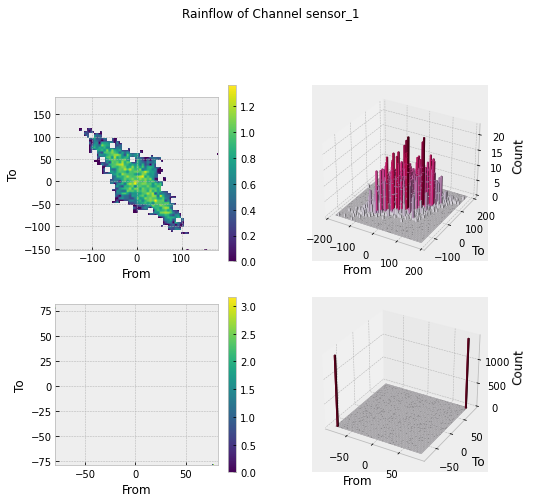

In [15]:
colormap = cm.ScalarMappable()
cmap = cm.get_cmap('PuRd')

fig = plt.figure(figsize = (8,11))                     # Plot of size 8*11
fig.suptitle('Rainflow of Channel ' + rfcChan.value) 


for i, rf_act in enumerate(rainflow):
    
    
    # 2D Plot 
    
    ax = fig.add_subplot(3,2,2*(i+1)-1)                # Subplot -- Grid parameters (3*2 grid, subplot index) 
    froms = rf_act.index.get_level_values('from').mid  # Accesses 'from' indices and gets mid value
    tos = rf_act.index.get_level_values('to').mid      # Accesses 'to' indices and gets mid value
    
    # Gets the shape of the dataset(histogram) and reshapes the values of the dataset into a 2D array #
    # Flip function - To plot increasing order (from bottom of the plot)
    counts = np.flipud((rf_act.values.reshape(rf_act.index.levshape).T))#.ravel()
    print(np.log10(counts))
    
    ax.set_xlabel('From')
    ax.set_ylabel('To')
    pl = ax.imshow(np.log10(counts), extent=[froms.min(), froms.max(), tos.min(), tos.max()])
    fig.colorbar(pl)
  
    
    
    # 3D Plot
    
    ax = fig.add_subplot(3,2,2*(i+1), projection='3d')          # For 3D subplots
    bottom = np.zeros_like(counts.ravel())
    
    # Gets the ranges of all the from and to indices(length) and finds out the minimum one #
    width = rf_act.index.get_level_values('from').length.min()
    depth = rf_act.index.get_level_values('to').length.min()    # For setting width and depth(minimum value)nof the bar graph 
    
    
    max_height = np.max(counts.ravel())   # get range of colorbars
    min_height = np.min(counts.ravel())
    rgba = [cmap((k-min_height)/max_height) for k in counts.ravel()]
    
    
    ax.set_xlabel('From')
    ax.set_ylabel('To')
    ax.set_zlabel('Count')
    pl3= ax.bar3d(froms.ravel(), tos.ravel(), bottom, width, depth, counts.ravel(), shade=True, color=rgba, zsort='average')
    

# 7. Meanstress transformation

Creates widget for asking user input of the required slope values and the stress ratio (R_Goal)

In [16]:
meanstress_para = ['M', 'M2', 'R_Goal']
values = [0.3,0.2,-1]
child = [widgets.FloatText(description=name) for name in meanstress_para]
tab_mean = widgets.Tab()
tab_mean.children = child
for i in range(len(child)):
    tab_mean.set_title(i, meanstress_para[i])
    tab_mean.children[i].value = values[i]

tab_mean

The following cell does means stress transformation on the stress cycle and transforms to an equivalent stress cycle with zero mean stress

In [17]:
transformed = []
for rf_act in rainflow:
    transformed.append(rf_act.meanstress_hist.FKM_goodman(pd.Series({'M': tab_mean.children[0].value,
                                                                     'M2': tab_mean.children[1].value})
                                                          , R_goal = tab_mean.children[2].value))
    
transformed

[                                          frequency
 range                                              
 (0.0, 5.661779169335807]                        226
 (5.661779169335807, 11.323558338671614]         262
 (11.323558338671614, 16.98533750800742]         212
 (16.98533750800742, 22.647116677343227]         197
 (22.647116677343227, 28.308895846679036]        213
 ...                                             ...
 (345.3685293294842, 351.03030849882003]           0
 (351.03030849882003, 356.6920876681558]           0
 (356.6920876681558, 362.35386683749164]           1
 (362.35386683749164, 368.01564600682747]          0
 (368.01564600682747, 373.67742517616324]          0
 
 [66 rows x 1 columns],
                                          frequency
 range                                             
 (0.0, 2.576628615363445]                         0
 (2.576628615363445, 5.15325723072689]            0
 (5.15325723072689, 7.729885846090335]            0
 (7.729885846090335, 10.3

In [18]:
child = [widgets.FloatText(description=name) for name in files]
tab_repeat = widgets.Tab()
tab_repeat.children = child
for i in range(len(child)):
    tab_repeat.set_title(i, files[i])
    tab_repeat.children[i].value = int(50/(i+1))

tab_repeat


In [19]:

for ii in range(len(files)):
    transformed[ii] = transformed[ii]*tab_repeat.children[ii].value
    
range_only_total = combine_hist(transformed,method = "sum")
display(range_only_total)   


frequency
range                                              
(0.0, 5.838709768377551]                    11300.0
(5.838709768377551, 11.677419536755101]     13100.0
(11.677419536755101, 17.51612930513265]     10600.0
(17.51612930513265, 23.354839073510202]      9850.0
(23.354839073510202, 29.193548841887754]    10650.0
...                                             ...
(344.48387633427546, 350.322586102653]          0.0
(350.322586102653, 356.1612958710306]           0.0
(356.1612958710306, 362.00000563940813]        50.0
(362.00000563940813, 367.8387154077857]         0.0
(367.8387154077857, 373.67742517616324]         0.0

[64 rows x 1 columns]

The following cell plots the data for whole dataset and for the datas from different sensors (wn, sine) in the following manner  

                  I) Amplitude vs Cycles(Frequency)
                 II) Amplitude vs Cumulative sum of the cycles

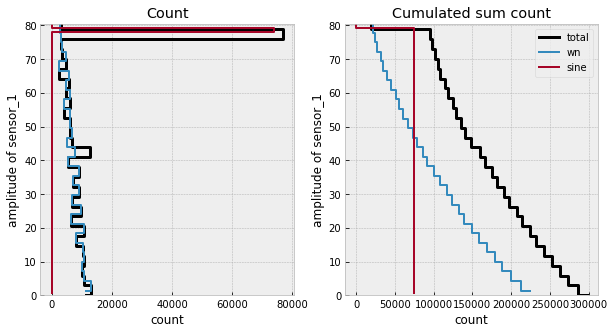

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))
amplitude = range_only_total.index.get_level_values('range').left.values[::-1]/2
cycles = range_only_total.values[::-1].ravel()


ax[0].step(cycles,amplitude,c = "black",linewidth = 3, label = "total")
ax[1].step(np.cumsum(cycles),amplitude,c = "black",linewidth = 3, label = "total")
ii=0
for range_only in transformed:
    amplitude = range_only.index.get_level_values('range').mid.values[::-1]/2
    cycles = range_only.values[::-1].ravel()
    ax[0].step(cycles,amplitude,label = files [ii])
    ax[1].step(np.cumsum(cycles),amplitude,label = files [ii])
    ii += 1
ax[0].set_title('Count')
ax[1].set_title('Cumulated sum count')
ax[1].legend()

for ai in ax:
    ai.xaxis.grid(True)
    ai.set_xlabel('count')
    ai.set_ylabel('amplitude of ' + rfcChan.value)
    ai.set_ylim((0,max(amplitude)))

    


# 8. Material Parameters

The following cell creates a pandas data set for the material parameters to be utilized using pd.series function

In [21]:
mat = pd.Series(index = ['k_1', 'ND_50', 'SD_50', '1/TN', '1/TS'],
                data = [8, 1.5e+06, 1.5e+02, 12, 1.1])
display(mat)

k_1            8.0
ND_50    1500000.0
SD_50        150.0
1/TN          12.0
1/TS           1.1
dtype: float64

# 9. Damage calculation

In [22]:
SNmethod = widgets.Dropdown(options = ['Miner Elementar','Miner Haibach','Miner original'])
display(SNmethod)

Dropdown(options=('Miner Elementar', 'Miner Haibach', 'Miner original'), value='Miner Elementar')

In [23]:
damage_calc = sn_curve.FiniteLifeCurve(**mat.drop(['1/TN','1/TS']))
damage = damage_calc.calc_damage(range_only_total,method = 'original')

print("\033[5m  Total Damage of channel %s: %.2e  \033[0m" % (rfcChan.value,damage.sum()))

2021-02-09 12:09:11,288 - pylife.strength.sn_curve - WARNING - Using all cycles



  Total Damage of channel sensor_1: 3.60e-01  


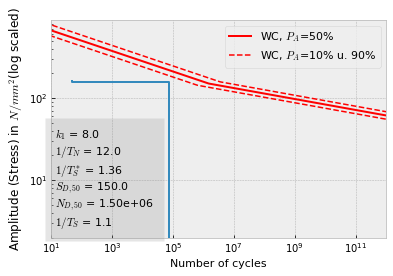

In [24]:
SRI = mat['SD_50']*(mat['ND_50']**(1/mat['k_1']))
# Plotting
diagdata = WoehlerCurveDiagrams(mat, fatigue_data = None, analyzer = None,
                                y_min=2, y_max=SRI, x_min=1e1, x_max=1e12, ax = None)
diagdata.plot_fitted_curve( k_2=15)
plt.step(np.cumsum(cycles),2*amplitude)


# 10. Local Stress Approach

# FE based propability calculation

The following cell reads a hdf file which contains dataset of each node like stress tensor components, coordinates etc., And then it computes vonmises stress of each element using equistress.mises function.

In [47]:

filename = 'plate_with_hole.h5'

stress = pd.read_hdf(filename, 'node_data')
stress['S13'] = np.zeros_like(stress['S11'])
stress['S23'] = np.zeros_like(stress['S11'])
display(stress)


""" Equivalent stress """
s_vm = stress.groupby('element_id').mean().equistress.mises().rename(columns={'mises': 'sigma_a'})
s_vm = 2*s_vm/s_vm.max()


""" Scale with """
ampl_fe = pd.DataFrame(data = amplitude, columns = ["ampl"] ,index =cycles)
s_vm_scaled = pd.DataFrame(data = ampl_fe.values*s_vm.transpose().values,index = ampl_fe.index,columns = s_vm.index)
display(s_vm_scaled)


E11       E22  E33       E12  PE11  PE22  PE33  PE12  \
node_id element_id                                                              
1734    1           0.000119 -0.000006  0.0 -0.000169   0.0   0.0   0.0   0.0   
1582    1           0.000133 -0.000035  0.0 -0.000133   0.0   0.0   0.0   0.0   
1596    1           0.000219 -0.000042  0.0 -0.000221   0.0   0.0   0.0   0.0   
4923    1           0.000126 -0.000020  0.0 -0.000151   0.0   0.0   0.0   0.0   
4924    1           0.000176 -0.000038  0.0 -0.000177   0.0   0.0   0.0   0.0   
...                      ...       ...  ...       ...   ...   ...   ...   ...   
3812    4770        0.000170 -0.000040  0.0 -0.000182   0.0   0.0   0.0   0.0   
12418   4770        0.000152 -0.000031  0.0 -0.000177   0.0   0.0   0.0   0.0   
14446   4770        0.000158 -0.000032  0.0 -0.000171   0.0   0.0   0.0   0.0   
14614   4770        0.000168 -0.000038  0.0 -0.000171   0.0   0.0   0.0   0.0   
14534   4770        0.000157 -0.000035  0.0 -0.000181   0.0   0.0   0.0   0.0   

                          S11       S22  S33        S12          x         y  \
node_id element_id                                                             
1734    1           27.080811  6.927080  0.0 -13.687358  14.897208  5.269875   
1582    1           28.319006  1.178649  0.0 -10.732705  14.555333  5.355806   
1596    1           47.701195  5.512213  0.0 -17.866833  14.630658  4.908741   
4923    1           27.699907  4.052865  0.0 -12.210032  14.726271  5.312840   
4924    1           38.010101  3.345431  0.0 -14.299768  14.592996  5.132274   
...                       ...       ...  ...        ...        ...       ...   
3812    4770        36.527439  2.470588  0.0 -14.706686 -13.189782 -5.691876   
12418   4770        32.868889  3.320898  0.0 -14.260107 -13.560289 -5.278386   
14446   4770        34.291058  3.642457  0.0 -13.836027 -13.673285 -5.569107   
14614   4770        36.063541  2.828889  0.0 -13.774759 -13.389065 -5.709927   
14534   4770        33.804211  2.829817  0.0 -14.580153 -13.276068 -5.419206   

                      z  S13  S23  
node_id element_id                 
1734    1           0.0  0.0  0.0  
1582    1           0.0  0.0  0.0  
1596    1           0.0  0.0  0.0  
4923    1           0.0  0.0  0.0  
4924    1           0.0  0.0  0.0  
...                 ...  ...  ...  
3812    4770        0.0  0.0  0.0  
12418   4770        0.0  0.0  0.0  
14446   4770        0.0  0.0  0.0  
14614   4770        0.0  0.0  0.0  
14534   4770        0.0  0.0  0.0  

[37884 rows x 17 columns]

element_id       1          2          3          4          5          6     \
50.0        31.406685  28.532720  49.916363  24.028734  33.987318  57.059738   
74000.0     30.904178  28.076197  49.117701  23.644274  33.443521  56.146782   
50.0        30.401671  27.619673  48.319039  23.259815  32.899724  55.233826   
0.0         29.899164  27.163150  47.520377  22.875355  32.355927  54.320870   
0.0         29.396657  26.706626  46.721715  22.490895  31.812130  53.407914   
...               ...        ...        ...        ...        ...        ...   
0.0          2.261281   2.054356   3.593978   1.730069   2.447087   4.108301   
0.0          1.758774   1.597832   2.795316   1.345609   1.903290   3.195345   
0.0          1.256267   1.141309   1.996655   0.961149   1.359493   2.282390   
0.0          0.753760   0.684785   1.197993   0.576690   0.815696   1.369434   
0.0          0.251253   0.228262   0.399331   0.192230   0.271899   0.456478   

element_id       7          8          9          10    ...       4761  \
50.0        11.880753  50.965922  24.556565  50.046267  ...  20.741826   
74000.0     11.690660  50.150468  24.163660  49.245526  ...  20.409957   
50.0        11.500568  49.335013  23.770755  48.444786  ...  20.078088   
0.0         11.310476  48.519558  23.377850  47.644046  ...  19.746218   
0.0         11.120384  47.704103  22.984945  46.843305  ...  19.414349   
...               ...        ...        ...        ...  ...        ...   
0.0          0.855414   3.669546   1.768073   3.603331  ...   1.493411   
0.0          0.665322   2.854092   1.375168   2.802591  ...   1.161542   
0.0          0.475230   2.038637   0.982263   2.001851  ...   0.829673   
0.0          0.285138   1.223182   0.589358   1.201110  ...   0.497804   
0.0          0.095046   0.407727   0.196453   0.400370  ...   0.165935   

element_id       4762       4763       4764       4765       4766       4767  \
50.0        35.520818  22.371370  24.751929  24.485617  35.981645  30.778307   
74000.0     34.952485  22.013429  24.355898  24.093847  35.405939  30.285854   
50.0        34.384151  21.655487  23.959868  23.702077  34.830233  29.793401   
0.0         33.815818  21.297545  23.563837  23.310307  34.254526  29.300948   
0.0         33.247485  20.939603  23.167806  22.918537  33.678820  28.808495   
...               ...        ...        ...        ...        ...        ...   
0.0          2.557499   1.610739   1.782139   1.762964   2.590678   2.216038   
0.0          1.989166   1.252797   1.386108   1.371195   2.014972   1.723585   
0.0          1.420833   0.894855   0.990077   0.979425   1.439266   1.231132   
0.0          0.852500   0.536913   0.594046   0.587655   0.863559   0.738679   
0.0          0.284167   0.178971   0.198015   0.195885   0.287853   0.246226   

element_id       4768       4769       4770  
50.0        28.667669  33.450584  31.761535  
74000.0     28.208986  32.915375  31.253350  
50.0        27.750303  32.380166  30.745166  
0.0         27.291621  31.844956  30.236981  
0.0         26.832938  31.309747  29.728797  
...               ...        ...        ...  
0.0          2.064072   2.408442   2.286831  
0.0          1.605389   1.873233   1.778646  
0.0          1.146707   1.338023   1.270461  
0.0          0.688024   0.802814   0.762277  
0.0          0.229341   0.267605   0.254092  

[63 rows x 4770 columns]

## Damage Calculation

The following cell calculates the number of cycles to falure for a given stress amplitude

In [26]:
N = damage_calc.calc_N(s_vm_scaled,ignore_limits = True)
print(N)

2021-02-09 12:09:12,679 - pylife.strength.sn_curve - WARNING - Using all cycles



element_id          1             2             3             4     \
50.0        4.061108e+11  8.751367e+11  9.974196e+09  3.459188e+12   
74000.0     4.620445e+11  9.956693e+11  1.134794e+10  3.935622e+12   
50.0        5.267951e+11  1.135202e+12  1.293823e+10  4.487158e+12   
0.0         6.019341e+11  1.297120e+12  1.478367e+10  5.127180e+12   
0.0         6.893468e+11  1.485488e+12  1.693055e+10  5.871748e+12   
...                  ...           ...           ...           ...   
0.0         5.623214e+20  1.211758e+21  1.381077e+19  4.789765e+21   
0.0         4.198947e+21  9.048398e+21  1.031273e+20  3.576597e+22   
0.0         6.196759e+22  1.335353e+23  1.521941e+21  5.278302e+23   
0.0         3.689391e+24  7.950345e+24  9.061247e+22  3.142565e+25   
0.0         2.420609e+28  5.216221e+28  5.945084e+26  2.061837e+29   

element_id          5             6             7             8     \
50.0        2.159166e+11  3.421237e+09  9.684333e+14  8.444661e+09   
74000.0     2.45654

In [27]:
d_mesh_cycle =  1/(N.div(N.index.values, axis = 'index'))
print(d_mesh_cycle)

element_id          1             2             3             4     \
50.0        1.231191e-10  5.713393e-11  5.012936e-09  1.445426e-11   
74000.0     1.601577e-07  7.432187e-08  6.521006e-06  1.880262e-08   
50.0        9.491357e-11  4.404504e-11  3.864515e-09  1.114291e-11   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                  ...           ...           ...           ...   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

element_id          5             6             7             8     \
50.0        2.315708e-10  1.461460e-08  5.162978e-14  5.920901e-09   
74000.0     3.01235

In [28]:
display(d_mesh_cycle.max())

element_id
1       1.601577e-07
2       7.432187e-08
3       6.521006e-06
4       1.880262e-08
5       3.012357e-07
            ...     
4766    4.753564e-07
4767    1.362476e-07
4768    7.718096e-08
4769    2.652167e-07
4770    1.752197e-07
Length: 4770, dtype: float64

In [29]:
d_mesh = d_mesh_cycle.sum()
d_mesh


element_id
1       1.603758e-07
2       7.442305e-08
3       6.529884e-06
4       1.882822e-08
5       3.016458e-07
            ...     
4766    4.760035e-07
4767    1.364331e-07
4768    7.728603e-08
4769    2.655777e-07
4770    1.754583e-07
Length: 4770, dtype: float64

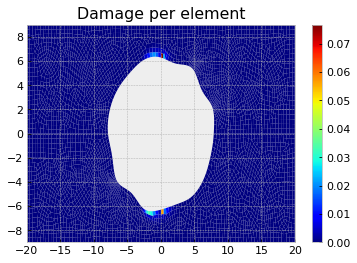

In [30]:
fig, ax = plt.subplots()
stress.join(pd.DataFrame(data = d_mesh,columns = ['d'])).meshplot.plot(ax, 'd', cmap='jet')
plt.title("Damage per element")
plt.show()


# 11. Wöhler analyzing tool

## Initialization

In [31]:
import numpy as np
import pandas as pd
from os import path
import sys, os
import json

import pylife.materialdata.woehler as woehler
import pylife.utils.diagrams.probability_data as probdiagram
from pylife.materialdata.woehler.controls.data_file_display import DataFileDisplay
from pylife.materialdata.woehler.controls.woehler_curve_analyzer_options import  WoehlerCurveAnalyzerOptions
from pylife.materialdata.woehler.controls.woehler_curve_data_plotter import  WoehlerCurveDataPlotter
from pylife.materialdata.woehler.controls.whole_woehler_curve_plotter import  WholeWoehlerCurvePlotter
from pylife.materialdata.woehler.diagrams.woehler_curve_diagrams import WoehlerCurveDiagrams


In [32]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import warnings
import pdb

##  Data import

Data is made up of two columns:
* The first column is made up of the load values
* The second column is made up of the load-cycle values

In [33]:
file_name = 'woehler-test-data.csv'


## Transforming data in csv to python arrays

In [34]:
data = pd.read_csv(file_name, sep='\t')
data.columns=['load', 'cycles']
data

load    cycles
0   284.39285   1369000
1   284.39285  10000000
2   284.39285  10000000
3   284.39285  10000000
4   284.39285  10000000
5   294.19950    411000
6   294.19950  10000000
7   294.19950  10000000
8   294.19950  10000000
9   294.19950   2295000
10  304.00615    570000
11  304.00615   7868000
12  304.00615   1745000
13  304.00615  10000000
14  304.00615    502000
15  313.81280    727000
16  313.81280    231000
17  313.81280   1826000
18  313.81280   1943000
19  313.81280    413000
20  323.61945   1842000
21  323.61945   2200000
22  323.61945    166000
23  323.61945    312000
24  323.61945    981000
25  333.42610    397000
26  333.42610    532000
27  333.42610    326000
28  333.42610    146000
29  333.42610    763000

In [35]:
ld_cyc_lim = None
data = woehler.determine_fractures(data, ld_cyc_lim)
data

load    cycles  fracture
0   284.39285   1369000      True
1   284.39285  10000000     False
2   284.39285  10000000     False
3   284.39285  10000000     False
4   284.39285  10000000     False
5   294.19950    411000      True
6   294.19950  10000000     False
7   294.19950  10000000     False
8   294.19950  10000000     False
9   294.19950   2295000      True
10  304.00615    570000      True
11  304.00615   7868000      True
12  304.00615   1745000      True
13  304.00615  10000000     False
14  304.00615    502000      True
15  313.81280    727000      True
16  313.81280    231000      True
17  313.81280   1826000      True
18  313.81280   1943000      True
19  313.81280    413000      True
20  323.61945   1842000      True
21  323.61945   2200000      True
22  323.61945    166000      True
23  323.61945    312000      True
24  323.61945    981000      True
25  333.42610    397000      True
26  333.42610    532000      True
27  333.42610    326000      True
28  333.42610    146000      True
29  333.42610    763000      True

In [36]:
fatigue_data = data.fatigue_data
display(fatigue_data)

In [37]:
woehler_curve_analyzer_options = WoehlerCurveAnalyzerOptions(fatigue_data)

RadioButtons(description='Select method', options=('Maximum likelihood 2 params', 'Maximum likelihood 5 params…

k_1      8.626165e+00
ND_50    1.326971e+06
SD_50    2.952540e+02
1/TN     1.205947e+01
1/TS     1.106812e+00
dtype: float64
BIC: 54.92940437923815


RadioButtons(description='Plot Type', options=('Only initial data', 'Slope', 'Pearl chain', 'Deviation in load…

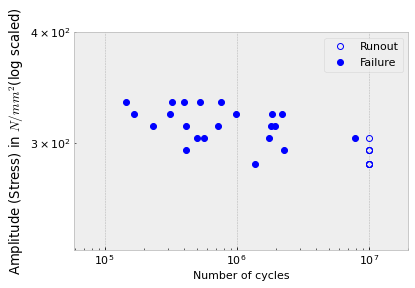

In [38]:
woehler_curve = woehler_curve_analyzer_options.woehler_curve
analyzer      = woehler_curve_analyzer_options.analyzer()
woehler_curve_data_plotter = WoehlerCurveDataPlotter(woehler_curve, fatigue_data, analyzer)

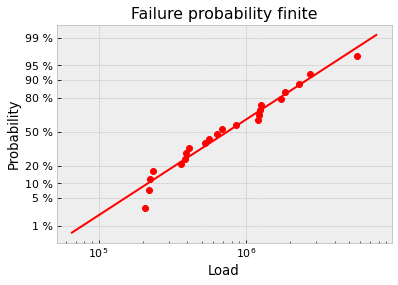

In [39]:
probdiag_finite = probdiagram.ProbabilityDataDiagram(analyzer.pearl_chain_estimator(),
                                                    occurrences_name='Load',
                                                    title='Failure probability finite')
probdiag_finite.plot()
if isinstance(analyzer, woehler.analyzers.probit.Probit):
    probdiag_infinite = probdiagram.ProbabilityDataDiagram(analyzer.pearl_chain_estimator(),
                                                        occurrences_name='Load',
                                                        title='Failure probability inffinite')
    probdiag_infinite.plot()

# Hotspot calculation demo

In [40]:
import numpy as np
import pylife
import pandas as pd
import scipy.stats as stats
import pylife.stress.equistress
import pylife.strength.meanstress
import pylife.mesh.meshplot
import pylife.mesh.hotspot
import matplotlib.pyplot as plt

In [41]:
filename = 'plate_with_hole.h5'
fe_res = pd.read_hdf(filename, 'node_data')
fe_res['S13'] = np.zeros_like(fe_res['S11'])
fe_res['S23'] = np.zeros_like(fe_res['S11'])
display(fe_res)

E11       E22  E33       E12  PE11  PE22  PE33  PE12  \
node_id element_id                                                              
1734    1           0.000119 -0.000006  0.0 -0.000169   0.0   0.0   0.0   0.0   
1582    1           0.000133 -0.000035  0.0 -0.000133   0.0   0.0   0.0   0.0   
1596    1           0.000219 -0.000042  0.0 -0.000221   0.0   0.0   0.0   0.0   
4923    1           0.000126 -0.000020  0.0 -0.000151   0.0   0.0   0.0   0.0   
4924    1           0.000176 -0.000038  0.0 -0.000177   0.0   0.0   0.0   0.0   
...                      ...       ...  ...       ...   ...   ...   ...   ...   
3812    4770        0.000170 -0.000040  0.0 -0.000182   0.0   0.0   0.0   0.0   
12418   4770        0.000152 -0.000031  0.0 -0.000177   0.0   0.0   0.0   0.0   
14446   4770        0.000158 -0.000032  0.0 -0.000171   0.0   0.0   0.0   0.0   
14614   4770        0.000168 -0.000038  0.0 -0.000171   0.0   0.0   0.0   0.0   
14534   4770        0.000157 -0.000035  0.0 -0.000181   0.0   0.0   0.0   0.0   

                          S11       S22  S33        S12          x         y  \
node_id element_id                                                             
1734    1           27.080811  6.927080  0.0 -13.687358  14.897208  5.269875   
1582    1           28.319006  1.178649  0.0 -10.732705  14.555333  5.355806   
1596    1           47.701195  5.512213  0.0 -17.866833  14.630658  4.908741   
4923    1           27.699907  4.052865  0.0 -12.210032  14.726271  5.312840   
4924    1           38.010101  3.345431  0.0 -14.299768  14.592996  5.132274   
...                       ...       ...  ...        ...        ...       ...   
3812    4770        36.527439  2.470588  0.0 -14.706686 -13.189782 -5.691876   
12418   4770        32.868889  3.320898  0.0 -14.260107 -13.560289 -5.278386   
14446   4770        34.291058  3.642457  0.0 -13.836027 -13.673285 -5.569107   
14614   4770        36.063541  2.828889  0.0 -13.774759 -13.389065 -5.709927   
14534   4770        33.804211  2.829817  0.0 -14.580153 -13.276068 -5.419206   

                      z  S13  S23  
node_id element_id                 
1734    1           0.0  0.0  0.0  
1582    1           0.0  0.0  0.0  
1596    1           0.0  0.0  0.0  
4923    1           0.0  0.0  0.0  
4924    1           0.0  0.0  0.0  
...                 ...  ...  ...  
3812    4770        0.0  0.0  0.0  
12418   4770        0.0  0.0  0.0  
14446   4770        0.0  0.0  0.0  
14614   4770        0.0  0.0  0.0  
14534   4770        0.0  0.0  0.0  

[37884 rows x 17 columns]

In [42]:
fe_res["vM"] = pylife.stress.equistress.mises(fe_res["S11"],fe_res["S22"],fe_res["S33"],fe_res["S12"],fe_res["S13"],fe_res["S23"])
display(fe_res["vM"].sort_values(ascending = False))

node_id  element_id
5        456           287.099222
9        2852          270.115389
6433     456           260.993366
11217    2852          243.603037
119      456           236.079927
                          ...    
491      3933            1.218400
8021     1437            0.874036
6470     470             0.819183
306      2538            0.472104
         2525            0.436058
Name: vM, Length: 37884, dtype: float64

In [43]:
display(fe_res)

E11       E22  E33       E12  PE11  PE22  PE33  PE12  \
node_id element_id                                                              
1734    1           0.000119 -0.000006  0.0 -0.000169   0.0   0.0   0.0   0.0   
1582    1           0.000133 -0.000035  0.0 -0.000133   0.0   0.0   0.0   0.0   
1596    1           0.000219 -0.000042  0.0 -0.000221   0.0   0.0   0.0   0.0   
4923    1           0.000126 -0.000020  0.0 -0.000151   0.0   0.0   0.0   0.0   
4924    1           0.000176 -0.000038  0.0 -0.000177   0.0   0.0   0.0   0.0   
...                      ...       ...  ...       ...   ...   ...   ...   ...   
3812    4770        0.000170 -0.000040  0.0 -0.000182   0.0   0.0   0.0   0.0   
12418   4770        0.000152 -0.000031  0.0 -0.000177   0.0   0.0   0.0   0.0   
14446   4770        0.000158 -0.000032  0.0 -0.000171   0.0   0.0   0.0   0.0   
14614   4770        0.000168 -0.000038  0.0 -0.000171   0.0   0.0   0.0   0.0   
14534   4770        0.000157 -0.000035  0.0 -0.000181   0.0   0.0   0.0   0.0   

                          S11       S22  S33        S12          x         y  \
node_id element_id                                                             
1734    1           27.080811  6.927080  0.0 -13.687358  14.897208  5.269875   
1582    1           28.319006  1.178649  0.0 -10.732705  14.555333  5.355806   
1596    1           47.701195  5.512213  0.0 -17.866833  14.630658  4.908741   
4923    1           27.699907  4.052865  0.0 -12.210032  14.726271  5.312840   
4924    1           38.010101  3.345431  0.0 -14.299768  14.592996  5.132274   
...                       ...       ...  ...        ...        ...       ...   
3812    4770        36.527439  2.470588  0.0 -14.706686 -13.189782 -5.691876   
12418   4770        32.868889  3.320898  0.0 -14.260107 -13.560289 -5.278386   
14446   4770        34.291058  3.642457  0.0 -13.836027 -13.673285 -5.569107   
14614   4770        36.063541  2.828889  0.0 -13.774759 -13.389065 -5.709927   
14534   4770        33.804211  2.829817  0.0 -14.580153 -13.276068 -5.419206   

                      z  S13  S23         vM  
node_id element_id                            
1734    1           0.0  0.0  0.0  33.996987  
1582    1           0.0  0.0  0.0  33.399850  
1596    1           0.0  0.0  0.0  54.777007  
4923    1           0.0  0.0  0.0  33.446991  
4924    1           0.0  0.0  0.0  44.070962  
...                 ...  ...  ...        ...  
3812    4770        0.0  0.0  0.0  43.577209  
12418   4770        0.0  0.0  0.0  39.903508  
14446   4770        0.0  0.0  0.0  40.478974  
14614   4770        0.0  0.0  0.0  42.140169  
14534   4770        0.0  0.0  0.0  41.143837  

[37884 rows x 18 columns]

In [44]:
threshold = .5 # factor of the maximum local value
fe_res['hotspot'] = fe_res.hotspot.calc("vM", threshold)
display(fe_res[['x', 'y', 'z', 'vM', 'hotspot']])

x         y    z         vM  hotspot
node_id element_id                                              
1734    1           14.897208  5.269875  0.0  33.996987        0
1582    1           14.555333  5.355806  0.0  33.399850        0
1596    1           14.630658  4.908741  0.0  54.777007        0
4923    1           14.726271  5.312840  0.0  33.446991        0
4924    1           14.592996  5.132274  0.0  44.070962        0
...                       ...       ...  ...        ...      ...
3812    4770       -13.189782 -5.691876  0.0  43.577209        0
12418   4770       -13.560289 -5.278386  0.0  39.903508        0
14446   4770       -13.673285 -5.569107  0.0  40.478974        0
14614   4770       -13.389065 -5.709927  0.0  42.140169        0
14534   4770       -13.276068 -5.419206  0.0  41.143837        0

[37884 rows x 5 columns]

In [45]:
display(fe_res["hotspot"].sort_values(ascending = False))

node_id  element_id
3062     2453          4
13021    3768          3
3904     3762          3
3918     3967          3
4017     3767          3
                      ..
10299    3145          0
10281    3145          0
10305    3145          0
3333     3145          0
1734     1             0
Name: hotspot, Length: 37884, dtype: int64

In [46]:
fe_res['hotspot'].max()

4